## Test on Hold out Set

### Score models and evaluate

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.font_manager as mfm
from display import Disp
from sklearn.svm import SVR
from kss_df import KssDf, KssDfType
from kss_speech import KssSpeech
from audio import Audio
from filename_versioner import FilenameVersioner

from scorers import ConvVar

font_path = '/Users/dev/Fonts/Noto_Sans_KR/NotoSansKR-Regular.otf'
k_prop = mfm.FontProperties(fname=font_path)
plt.style.use('dark_background')

# Display handler with some nice helpers
disp = Disp(display)
# Uncomment to see the source code
# disp.code('display.py', label='display.py ')


# disp examples
# disp(IPython.display.Audio('./data/korean-single-speaker/kss/1/1_0000.wav'))
# disp_file_source('marker_df.py', label='marker_df')
# disp_audio_file('./data/korean-single-speaker/kss/1/1_0000.wav', label='1_0000.wav')

In [2]:
#TODO: Figure out a way to abstract all models so we can just use the model name, and not worry about the type of model

import joblib
tng_data_dir = './data/model'

from pipewrap import PipeWrap
available_models = [ 'svr_rbf', 'svc_lin', 'svc_rbf', 'logr', 'tree', 'ada', 'ada-sw-vote']
fv_models = [FilenameVersioner((model, 'joblib'), base_dir=tng_data_dir ) for model in available_models]


In [3]:
model_files = [fv.get_latest_path() for fv in fv_models]
model_versions = [fv.get_latest_data()[1].split('.') for fv in fv_models]
models = [joblib.load(model_file) for model_file in model_files]

In [4]:
from custom_loss import conv_loss
import keras.models
from model_wrapper import KerasWrap

from keras.utils.generic_utils import get_custom_objects

# TODO: Is there a better way? This is needed so that the custom 'conv_loss' function is registered
# See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object
get_custom_objects().update({'conv_loss': conv_loss})

available_keras_models = ['cnn']
keras_fvs = [FilenameVersioner((model, 'keras'), base_dir=tng_data_dir ) for model in available_keras_models]
keras_files = [fv.get_latest_path() for fv in keras_fvs]
keras_versions = [fv.get_latest_data()[1].split('.') for fv in keras_fvs]
keras_bare_models = [keras.models.load_model(model_file) for model_file in keras_files]
keras_models = [ KerasWrap(model_name, model) for (model_name, model) in zip(available_keras_models, keras_bare_models)]

In [5]:
all_available_models = available_models + available_keras_models
all_models = models + keras_models

In [6]:
fv_shared_params = FilenameVersioner(('shared_params', 'joblib'), base_dir=tng_data_dir)

### Get X, y Test Data from KSS Ids

In [7]:
from kss_df import KssDf


shared_params = joblib.load(fv_shared_params.get_latest_path())
kss_tst_ids = shared_params['kss']['tst_ids']
audio_params = shared_params['audio']

kdfs = [KssDf(id) for id in kss_tst_ids]

# Below will be deprecated eventually
char_trn_dfs = [kdf.load_csv(type=KssDfType.CHAR) for kdf in kdfs]
syl_trn_dfs = [kdf.load_csv(type=KssDfType.SYL) for kdf in kdfs]

X_tst_list = [Audio(kdf.audio_path, **audio_params).rms.squeeze() for kdf in kdfs]

sample_rate = 44100
def kss_speech_maker(kdf, **kwargs):
    a = Audio(kdf.audio_path, **kwargs)
    assert a.sr == sample_rate, f'Mismatch sample rate, expected {sample_rate}, but got {a.sr} for {kdf.audio_path}'
    df = kdf.load_csv(type=KssDfType.SYL)
    return KssSpeech(df, a)

# Add sample rate to shared params
# TODO: Verify if audio_params being used

audio_params['sr'] = sample_rate

#TODO: kspeech windowing (sliding window calcs) should not reduce training size
# Audio Comprehension

#y_tst_list is the ground truth y values
y_tst_list = [ kss_speech_maker(kdf).is_speech for kdf in kdfs]

# print(y_tst_list)

Audio[WARNING]: Modifying input wav from size 74459 to 74496
Audio[INFO]: change in number of samples: 37 [should be less than hop length: 64]
/Users/dev/Projects/korean-ml/venv/lib/python3.9/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(
Audio[INFO]: a.to_rms size: 1165, reduction factor 1164.0
Audio[WARNING]: Modifying input wav from size 121857 to 121920
Audio[INFO]: change in number of samples: 63 [should be less than hop length: 64]
Audio[INFO]: a.to_rms size: 1906, reduction factor 1905.0
Audio[WARNING]: Modifying input wav from size 74459 to 74496
Audio[INFO]: change in number of samples: 37 [should be less than hop length: 64]
Audio[INFO]: a.to_rms size: 1165, reduction factor 1164.0
Audio[WARNING]: Modifying input wav from size 121857 to 121920
Audio[INFO]: change in number of samples: 63 [should be les

### Predict and Score
For each model of interest, get the predictions and score it against the ground truth



Model: svc_lin
KSS ID: 1_0005
KSS ID: 1_0006
Model: svc_rbf
KSS ID: 1_0005
KSS ID: 1_0006
Model: logr
KSS ID: 1_0005
KSS ID: 1_0006
Model: tree
KSS ID: 1_0005
KSS ID: 1_0006
Model: ada
KSS ID: 1_0005
KSS ID: 1_0006
Model: ada-sw-vote
KSS ID: 1_0005
KSS ID: 1_0006
Model: cnn
KSS ID: 1_0005
KSS ID: 1_0006


SlidingWindow[INFO]: np sliding window shape: (1357, 128)


swX, swy shapes (1165, 128) (1165,)


SlidingWindow[INFO]: np sliding window shape: (1357, 128)


swX, swy shapes (1165, 128) (1165,)


SlidingWindow[INFO]: np sliding window shape: (2098, 128)
SlidingWindow[INFO]: np sliding window shape: (2098, 128)


swX, swy shapes (1906, 128) (1906,)
swX, swy shapes (1906, 128) (1906,)


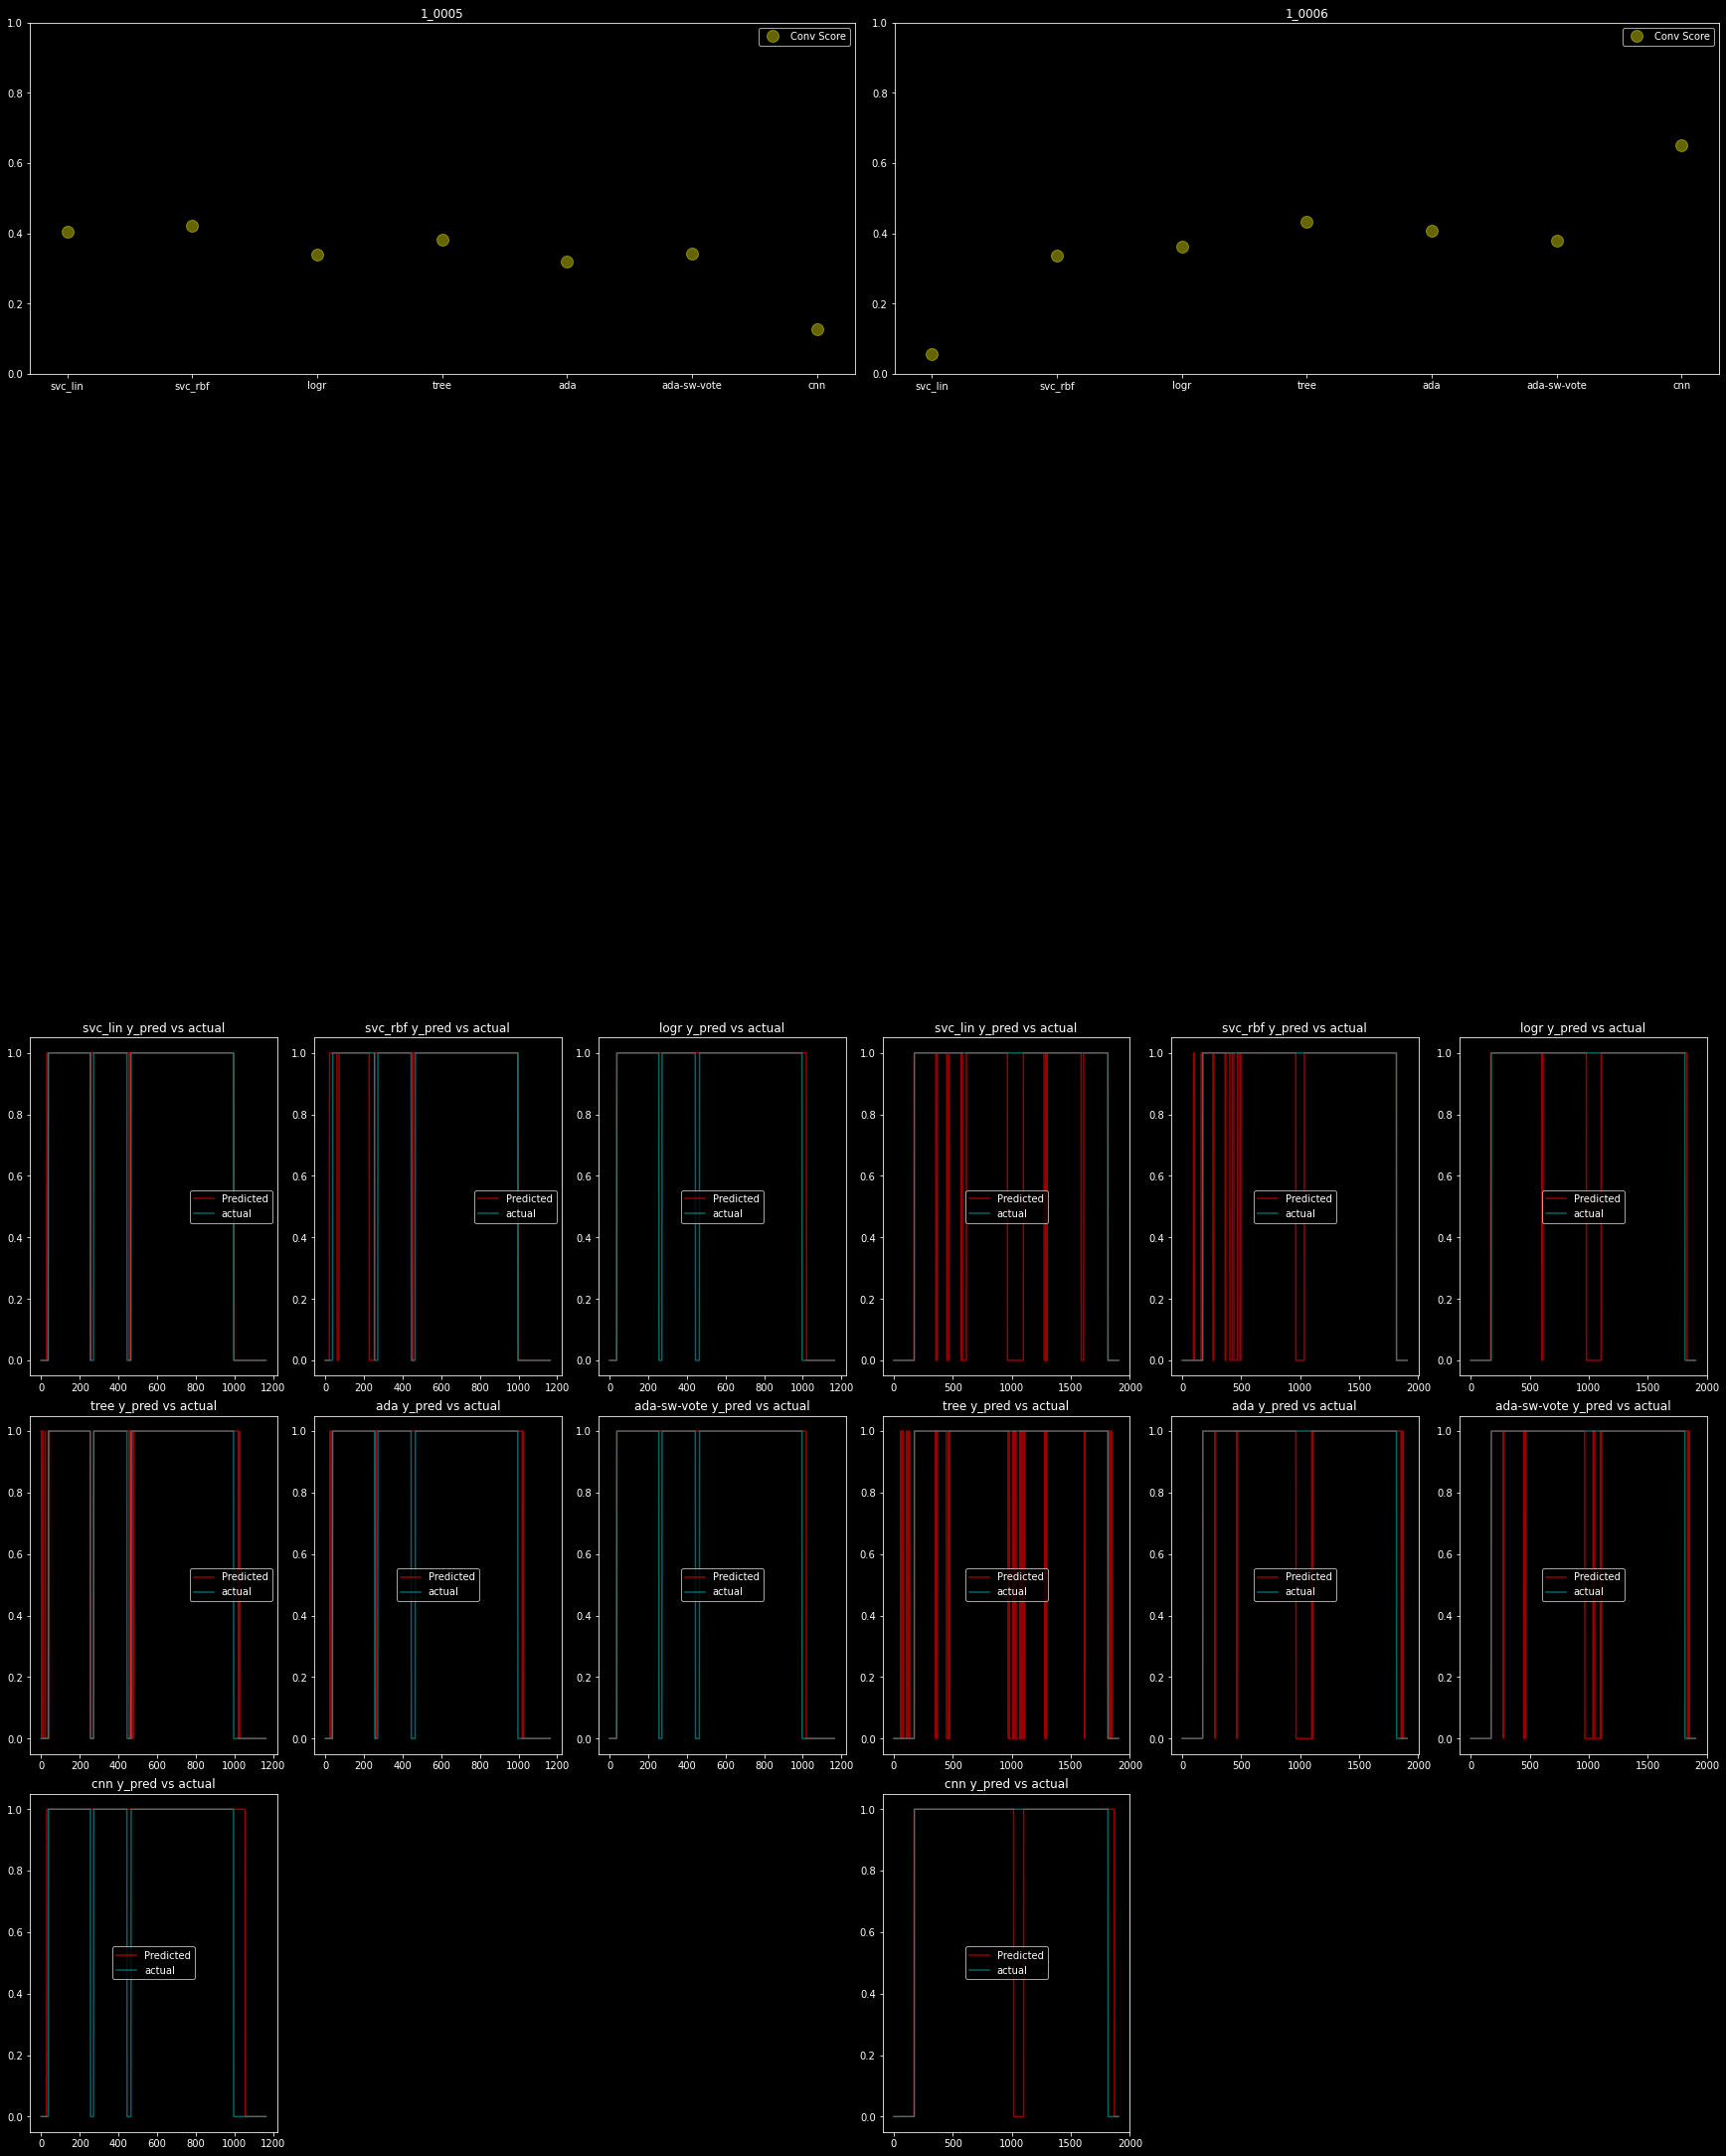

In [8]:
import matplotlib.gridspec as gridspec
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report


def get_y_pred(model, X_tst):
    try:
        return model.pipe.predict(X_tst)
    except AttributeError:
        return model.predict(X_tst)

def get_metrics(model, X_tst, y_tst):
    y_pred = get_y_pred(model, X_tst)
    report = classification_report(y_tst, y_pred, output_dict=True)
    return report
    # # y_pred = model.pipe.predict(X_tst)
    # cm = plot_confusion_matrix(clf, X_tst, y_tst)
    # cm.ax_.set_title(f'{model_name} - {kdf.id}')
    # cm.im_.set_clim(0, 1165)
    # cm.confusion_matrix
    # print(f'KSS ID: {kdf.id}')
    # print(classification_report(y_tst, y_pred))

def get_predictor(model):
    try:
        model.pipe.predict
        return model.pipe
    except AttributeError:
        return model

model_slicer = slice(1,None)
# print(models)
# print(available_models[model_slicer])
for model_name, model in zip(all_available_models[model_slicer], all_models[model_slicer]):
    print(f'Model: {model_name}')

    for kdf, X_tst, y_tst in zip(kdfs, X_tst_list, y_tst_list):
        print(f'KSS ID: {kdf.id}')

        # print(metrics(model_name, model, kdf, X_tst, y_tst)['accuracy'])

import matplotlib.transforms as transforms
fig = plt.figure(constrained_layout=True, figsize=(24,30))


import json
mod_names = all_available_models[model_slicer]
# print(x_tick_labels)
mods = all_models[model_slicer]
# ax1 = fig.add_subplot(2,4,5)
# ax1 = fig.add_subplot(2,4,6)
# ax1 = fig.add_subplot(2,4,8)





conv_var = ConvVar(var_penalty=20)
# from sklearn.metrics import make_scorer
# ticker_score = make_scorer(ticker_error)

for i, kdf in enumerate(kdfs):
    # ax = fig.add_subplot(gs[0,i)
    ax = fig.add_subplot(6,2,i+1)


    ax.set_ylim(0.0,1)
    ax.set_title(kdf.id)
    # ax.plot([1, 1, 1, 1, 2, 1])
    # plt.xticks(np.arange(0, len(x_tick_labels)))
    ax.set_xticks(np.arange(len(mod_names)))
    ax.set_xticklabels(mod_names)

    accuracy = []
    macro_f1 = []
    macro_recall = [] #'macro avg''recall'
    macro_precision = []
    weighted_f1 = []
    weighted_recall = []
    weighted_precision = []
    conv_scores = []
    # convolve_sc = []
    # corr_sc = []
    hamming_sc = []

    for j, m in enumerate(mods):
        # TODO: Figure out how to get metrics for Keras models, maybe use wrapper?
        # metrics = get_metrics(m, X_tst_list[i], y_tst_list[i])
        # print(json.dumps(metrics, indent=2))
        # accuracy.append(metrics['accuracy'])
        # macro_f1.append(metrics['macro avg']['f1-score'])
        # macro_recall.append(metrics['macro avg']['recall'])
        # macro_precision.append(metrics['macro avg']['precision'])
        # weighted_f1.append(metrics['weighted avg']['f1-score'])
        # weighted_recall.append(metrics['weighted avg']['recall'])
        # weighted_precision.append(metrics['weighted avg']['precision'])
        conv_score = conv_var.score(y_tst_list[i], get_predictor(m).predict(X_tst_list[i]))
        conv_scores.append(conv_score)

        # TODO: Figure out way to abstract sk and keras models (and how to plot cm)

        # print(kdf.id, mod_names[j], t_err)
        row_add = j // 3
        # cm_plt_id =  3*i + j + 7 + 3*row_add
        # cm = plot_confusion_matrix(get_predictor(m), X_tst_list[i], y_tst_list[i], ax=fig.add_subplot(6,6,cm_plt_id), colorbar=False)
        # cm.ax_.set_title(f'{mod_names[j]} - {kdf.id}')
        # cm.im_.set_clim(0, 1165)
        # # cm.im_.colorbar.remove()
        # cm.confusion_matrix

        y_plt_id = 3*i + j + 19 + 3*row_add
        ax2 = fig.add_subplot(6,6, y_plt_id)
        ax2.plot(get_y_pred(get_predictor(m), X_tst_list[i]), color='red', alpha=0.6, label='Predicted')
        ax2.plot(y_tst_list[i], alpha=0.4, color='cyan', label='actual')
        ax2.set_title(f'{mod_names[j]} y_pred vs actual')
        ax2.legend()
    # print([get_metrics(m, X_tst_list[i], y_tst_list[i]) for m in mods])
    # ax.plot(accuracy, label='Accuracy', color='lime', alpha=0.4, linestyle='None', marker=7, markersize=12)
    # ax.plot(macro_f1, label='Macro F1', color='mistyrose', alpha=0.4, linestyle='None', marker=5, markersize=12)
    # ax.plot(macro_recall, label='Macro Recall', color='orangered', alpha=0.4, linestyle='None', marker=5, markersize=12)
    # ax.plot(macro_precision, label='Macro Precision', color='sienna', alpha=0.4, linestyle='None', marker=5, markersize=12)
    # ax.plot(weighted_f1, label='Weighted F1', color='azure', alpha=0.4, linestyle='None', marker=4, markersize=12)
    # ax.plot(weighted_recall, label='Weighted Recall', color='cyan', alpha=0.4, linestyle='None', marker=4, markersize=12)
    # ax.plot(weighted_precision, label='Weighted Precision', alpha=0.4, color='deepskyblue', linestyle='None', marker=4, markersize=12)
    ax.plot(conv_scores, label='Conv Score', alpha=0.4, color='yellow', linestyle='None', marker='o', markersize=12)
    ax.legend()

    # ax3_span = (3*i+19, 3*i+21)
    # ax3 = fig.add_subplot(4,6,ax3_span, title=f'Ground Truth: {kdf.id}')
    # ax3.plot(y_tst_list[i])

plt.show()


    # ax.plot(X_tst_list[i], color='lightblue', alpha=0.4, label='rms of audio (X)')
# # gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig, height_ratios=[1,2])
# ax1 = fig.add_subplot(gs[0, :])
# ax2 = fig.add_subplot(gs[1, :])
# axs[3].set_title(f'Difference to base Speech/No Speech Input')

In [9]:

for model_name, model in zip(available_models[1::], models[1::]):
    print(f'Model: {model_name}')

    for kdf, X_tst, y_tst in zip(kdfs, X_tst_list, y_tst_list):
        try:
            y_pred = model.pipe.predict(X_tst)
            clf = model.pipe
        except AttributeError:
            y_pred = model.predict(X_tst)
            clf = model
        # y_pred = model.pipe.predict(X_tst)
        # TODO: Figure out how to plot confusion matrix from Keras
        # cm = plot_confusion_matrix(clf, X_tst, y_tst)
        # cm.ax_.set_title(f'{model_name} - {kdf.id}')
        # cm.im_.set_clim(0, 1165)
        # cm.confusion_matrix
        # print(f'KSS ID: {kdf.id}')
        # print(classification_report(y_tst, y_pred))
        # print(classification_report(y_tst, y_pred))
    # print(model.pipe.predict())



# [(model_name, model.pipe.predict(X_pred)) for model_name, model in zip(available_models, models)]

Model: svc_lin
Model: svc_rbf
Model: logr
Model: tree
Model: ada
Model: ada-sw-vote


In [10]:
kss_id = "1_0006"

kdf_pred = KssDf(kss_id)
# shared_params = joblib.load(fv_shared_params.get_latest_path())
# audio_params = shared_params['audio']

a_orig = Audio(kdf_pred.audio_path, **audio_params)
X_pred = a_orig.rms.flatten()

print(a_orig.rms.shape)
print(X_pred.shape)

Audio[WARNING]: Modifying input wav from size 121857 to 121920
Audio[INFO]: change in number of samples: 63 [should be less than hop length: 64]
/Users/dev/Projects/korean-ml/venv/lib/python3.9/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(
Audio[INFO]: a.to_rms size: 1906, reduction factor 1905.0


(1, 1906)
(1906,)


# BELOW THIS IS REFERENCE

## Model Prediction

In [11]:

y_preds = [(model_name, model.pipe.predict(X_pred)) for model_name, model in zip(available_models, models)]

print(y_preds)

AttributeError: 'VotingClassifier' object has no attribute 'pipe'

In [ ]:
# A bit of a hack to get the offset.
# TODO: A better way is to save the AudioPlexer used for training
calc_offset = np.argmax(x_rms > 0.01) - np.argmax(y_pred > 0.8)
sw_offset = 64 # calc_offset

def align(y, offset):
    return np.pad(y, (offset, 0), 'minimum')

def delta(y1, y2, y1_offset, y2_offset):
    min_len = min(len(y1), len(y2))
    return align(y1, y1_offset)[0:min_len] - align(y2, y2_offset)[0:min_len]

def speech_base_delta(y, offset):
    return delta(y, y_rms, offset, 0)

# TODO: Move these into a class
def pred_threshold(pred_vals, thresh=0.5):
    return np.where(pred_vals > thresh, True, False)


def get_events_from_preds(preds):
    pred_pad = np.pad(preds, (0,0), 'minimum')

In [ ]:
fig, (ax1, ax2)  = plt.subplots(2, 1, figsize=(18,5))

y_pred_bool = pred_threshold(y_pred, 0.5)
ax1.set_title(f'Predicted Speech for Validation Data')
ax1.plot(x_rms, color='lightblue', alpha=0.8, label='rms')
ax1.plot(align(y_pred, sw_offset), color='cyan', alpha=0.6, label='speech prediction')
ax1.plot(align(1*y_pred_bool, sw_offset), color='hotpink', alpha=0.5, label='pred to boolean')
ax1.legend(loc='center right')

ax2.set_title(f'Predicted Speech vs Manual Speech')
ax2.plot(y_rms, color='lightblue', alpha=0.8, label='Manual')
ax2.plot(align(1*y_pred_bool, sw_offset), color='hotpink', alpha=0.5, label='Prediction')
ax2.legend(loc='center right')
plt.show()

In [ ]:

#TODO: Figure out where to do final alignment
# y_train_pred_bool_align = align(y_train_pred_bool, sw_offset)
y_pred_bool_align = align(y_pred_bool, sw_offset)

# TODO: Move these to a class
def get_intervals(bs_in):
    bs = np.pad(bs_in, (1,1), 'edge')
    d = np.diff(bs)
    ivl_idxs = np.where(d > 0)[0]
    disp.obj(bs[ivl_idxs], 'Testing for Vals')
    return ivl_idxs, bs[ivl_idxs]

y_pred_event_idxs, y_pred_event_vals = get_intervals(y_pred_bool_align)
disp.obj(y_pred_event_idxs, "Event Indices")
disp.obj(y_pred_event_vals, "Event Vaues")


fig, axs_  = plt.subplots(1, 1, figsize=(22,8), squeeze=False)
axs = axs_[:,0]
axs[0].set_title(f'Event Boundary Locations')
axs[0].plot(x_rms, color='slategray', alpha=0.4, label='rms of audio')
axs[0].plot(align(0.2*y_pred_bool+1.2, sw_offset), color='hotpink', alpha=0.4, label='speech prediction')
axs[0].vlines(y_pred_event_idxs, 0, 1.1, color='cyan', alpha=0.6, label="event bars")
axs[0].legend(loc='center right')
# axs[0].plot(delta(1*y_svr_pred, y_base, sw_offset, 0), color='cyan', alpha=0.5, label='pred bool - base')
plt.show()


y_pred_event_t = y_pred_event_idxs  * (ap.hop_length/ap.sr)
# add start event at t=0
# TODO: add end event at t=? (maybe ok to just add end padding??)
speech_event_t = np.pad(y_pred_event_t, (1, 0), constant_values=0.0)
disp.obj(speech_event_t, "Speech Event_t")

In [ ]:
tg_pred_path = f'{tg_dir}/{kss_id}.pred.{xy_version}.{tng_version}.TextGrid'

# audio_path = f'{tg_dir}/{audio_file}'
# tg = textgrid.TextGrid.fromFile(tg_path)

# TODO: This really needs to be a class as it should only be one per file.
import string
from pathlib import Path

# TODO: Combine vals into src, for tighter coupling
def make_textgrid(src, vals):
    ivl_template = string.Template(Path('./template/interval.template').read_text())
    item_template = string.Template(Path('./template/item.template').read_text())
    item_list_template = string.Template(Path('./template/itemlist.template').read_text())
    textgrid_template = string.Template(Path('./template/textgrid.template').read_text())

    item_lists_a = []
    for (item_idx, (item_name, event_t)) in enumerate(src):
        ivls_a = []
        # we're going to be taking pairs of data, so skip the last iteration
        ivls_size = len(event_t) - 1
        for i in range(ivls_size):
            ivl_dict = {
                'ivl_id': i+1,
                'ivl_xmin': event_t[i],
                'ivl_xmax': event_t[i+1],
                'ivl_text': f'{vals[i]}' if vals is not None else ' '
            }
            ivls_a.append(ivl_template.substitute(ivl_dict))

        ivls = '\n'.join(ivls_a)

        item_dict = {
            'item_name': item_name,
            'item_xmin': min(event_t),
            'item_xmax': max(event_t),
            'item__intervals_size': ivls_size,
            'item__intervals': ivls
        }
        item = item_template.substitute(item_dict)

        item_list_dict = {
            'item_list_id': item_idx+1,
            'item_list__items': item
        }
        item_lists_a.append(item_list_template.substitute(item_list_dict))

    item_lists = '\n'.join(item_lists_a)
    textgrid_dict = {
        'textgrid_xmin': min(event_t),
        'textgrid_xmax': max(event_t),
        'textgrid_size': len(item_lists_a),
        'textgrid__item_list': item_lists
    }
    return textgrid_template.substitute(textgrid_dict)

def save_textgrid(src, vals, tg_pred_path):
    with open(tg_pred_path, 'w') as f:
        print(f'saving textgrid to {tg_pred_path}')
        f.write(make_textgrid(src, vals))

tg_vals = np.where(y_pred_event_vals, ' ', '0')
textgrid_src = [('char', speech_event_t), ('syl', speech_event_t)]
print('Check to see if save is commented or not')
save_textgrid(textgrid_src, tg_vals, tg_pred_path)

In [ ]:
import pandas as pd
from kss_textgrid import KssTextGrid
# TODO: Compare Predicted vs Actual TextGrid

tg_dir = 'data/korean-single-speaker/kss/1'
# tg_file = '1_0003.TextGrid'
# audio_file = '1_0003.wav'
# tg_path = f'{tg_dir}/{tg_file}'
# audio_path = f'{tg_dir}/{audio_file}'
# print(tg_path)
# tg = textgrid.TextGrid.fromFile(tg_path)
val_kss_id = '1_0005'

syls_df_pred = KssTextGrid(val_kss_id, tg_dir, path=tg_pred_path).syls_df()
disp.obj(syls_df_pred[syls_df_pred['syl'] == '0'], f'Predicted Syl DF for {val_kss_id}')

assert(val_kss_id == kss_id, f'{val_kss_id} != {kss_id}')

syls_df_actual = KssTextGrid(val_kss_id, tg_dir).syls_df()
disp.obj(syls_df_actual[syls_df_actual['syl'] == '0'], f'Actual Syl DF for {val_kss_id}')